# Medical Insurance Cost Prediction
## Started 22/12/20
This is a look at predicting medical insurance costs using linear regression. It is a Kaggle project: https://www.kaggle.com/mirichoi0218/insurance.

There are a bunch of datasets in the GitHub repo mentioned on the Kaggle page above: https://github.com/stedy/Machine-Learning-with-R-datasets.

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.figure_factory as ff
import plotly.express as ex
import plotly.offline as pyo
import plotly.graph_objs as go
from plotly.subplots import make_subplots
pyo.init_notebook_mode()
sns.set_style('darkgrid')
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures, normalize
from sklearn.svm import SVR
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error as mse
import scikitplot as skplt
import eli5 #for purmutation importance
from eli5.sklearn import PermutationImportance
import shap #for SHAP values

/anaconda3/lib/python3.7/site-packages/dask/config.py:168: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  data = yaml.load(f.read()) or {}


/anaconda3/lib/python3.7/site-packages/sklearn/utils/deprecation.py:143: FutureWarning:

The sklearn.metrics.scorer module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.

/anaconda3/lib/python3.7/site-packages/sklearn/utils/deprecation.py:143: FutureWarning:

The sklearn.feature_selection.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.feature_selection. Anything that cannot be imported from sklearn.feature_selection is now part of the private API.

/anaconda3/lib/python3.7/site-packages/distributed/config.py:20: YAMLLoadWarning:

calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.

Using TensorF

### Load and investigate the data

In [2]:
df = pd.read_csv('../../data/insurance.csv')

In [3]:
df.head()

age     sex     bmi  children smoker     region      charges
0   19  female  27.900         0    yes  southwest  16884.92400
1   18    male  33.770         1     no  southeast   1725.55230
2   28    male  33.000         3     no  southeast   4449.46200
3   33    male  22.705         0     no  northwest  21984.47061
4   32    male  28.880         0     no  northwest   3866.85520

In [4]:
print('number of rows = %i' %len(df))

number of rows = 1338


In [5]:
mx = df['bmi'].max()
mn = df['bmi'].mean()
sd = df['bmi'].std()

print((mx - mn)/sd)

fig = ff.create_distplot([df['bmi']], group_labels=['bmi'], curve_type='normal')
fig.show()

3.684144724391159


The BMI data appears to be wll behaved, with no significant outliers. The maximum is ~3.7 sigma from the mean. 

In [6]:
fig = make_subplots(rows=2, cols=1)

tr1=go.Box(x=df['age'],name='Age Box Plot',boxmean=True)
tr2=go.Histogram(x=df['age'],name='Age Histogram')

fig.add_trace(tr1,row=1,col=1)
fig.add_trace(tr2,row=2,col=1)

fig.update_layout(height=700, width=1200, title_text="Ages of customers")
fig.show()

Intrestingly, the age distribution is fairly uniform, other than a large peak for 18 and 19 year olds! Could this be new drivers?

Will this peak cause a problem, with the younger categories lending more weight to the model? I will need to think about that.

In [7]:
ex.pie(df,names='smoker',title='Proportion of smokers vs non-smokers customers')

So around 20% of the customers are smokers. I would expect medical costs to be higher for smokers.

In [8]:
ex.pie(df,names='sex',title='Proportion of female and male customers')

The number of females and males are roughly the same.

In [9]:
ex.pie(df,names='children',title='Numbers of children')

In [10]:
ex.pie(df,names='region',title='Region')

The regions look fairly unform

In [11]:
fig = make_subplots(rows=2, cols=1)

tr1=go.Box(x=df['charges'],name='Charges Box Plot',boxmean=True)
tr2=go.Histogram(x=df['charges'],name='Charges Histogram')

fig.add_trace(tr1,row=1,col=1)
fig.add_trace(tr2,row=2,col=1)

fig.update_layout(height=700, width=1200, title_text="Charges made by customers")
fig.show()

I'm not really sure what we can glean from this. The distribution is clearly not Normal, but does this matter for a target variable? Would it be beneficial to have the higher charges better represented?

### Data preprocessing

Let's start by getting one-hot representations of sex, smoker, and region.

In [12]:
one_hots = ['sex', 'smoker', 'region']

df_onehot = df.copy()

for i in one_hots:
    df_onehot = pd.concat([df_onehot, pd.get_dummies(df_onehot[i], drop_first=True)], axis=1)
    
df_onehot.drop(columns=one_hots, inplace=True)
df_onehot.rename(columns={'yes': 'smoker'}, inplace=True)

df_onehot.head()
    

age     bmi  children      charges  male  smoker  northwest  southeast  \
0   19  27.900         0  16884.92400     0       1          0          0   
1   18  33.770         1   1725.55230     1       0          0          1   
2   28  33.000         3   4449.46200     1       0          0          1   
3   33  22.705         0  21984.47061     1       0          1          0   
4   32  28.880         0   3866.85520     1       0          1          0   

   southwest  
0          1  
1          0  
2          0  
3          0  
4          0

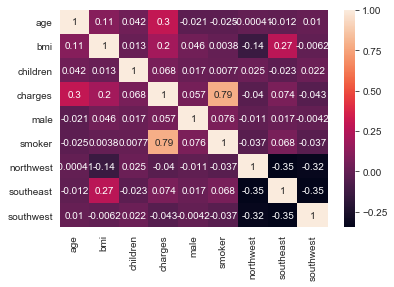

In [13]:
sns.heatmap(df_onehot.corr('pearson'),annot=True)

As we see here, age, BMI and smoker are most correlated with charges. Let's cut on the correlation with charges at 0.1, that will get rid of all the other columns.

In [14]:
cut_correlation = 0.1
# A cut of 0.3 was found to give the best scores for both cross-validation
# on the training set and the test set score for the decision tree.

corr = df_onehot.corr('pearson')
cut_df_onehot = df_onehot[corr['charges'][corr['charges'].abs()>cut_correlation].index]

cut_df_onehot.head()

age     bmi      charges  smoker
0   19  27.900  16884.92400       1
1   18  33.770   1725.55230       0
2   28  33.000   4449.46200       0
3   33  22.705  21984.47061       0
4   32  28.880   3866.85520       0

Smoker-non smoker has the biggest correlation with charges, but smokers are not well represented. I am a bit unsure whether this will cause a problem; although, I am under the impression it is more problematic when there is an imbalance in the target. Let us first build a simple linear regression model to see how we get on.

### Initial models

In [15]:
X_train, X_test, y_train, y_test = train_test_split(cut_df_onehot.drop('charges', 1), cut_df_onehot['charges'], test_size = 0.15, random_state=10)

I will try two approaches to start off with: with and without normalizing the data and look at the perfomance on the training set.

In [16]:
cf_lr = LinearRegression()
model_lr = cf_lr.fit(X_train, y_train)
y_pred_train_lr = model_lr.predict(X_train)
y_pred_test_lr = model_lr.predict(X_test)

RMSE = 5999.092246
RMSE = 6549.121562


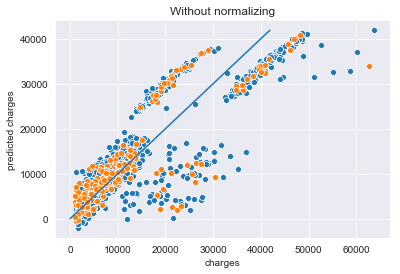

In [17]:
sns.scatterplot(y_train, y_pred_train_lr)
sns.scatterplot(y_test, y_pred_test_lr)
plt.ylabel('predicted charges')
plt.title('Without normalizing')
maxim = np.max(np.concatenate([y_pred_train_lr, y_pred_test_lr]))
plt.plot([0,maxim], [0,maxim])

print('RMSE = %f' %mse(y_train, y_pred_train_lr, squared=False))
print('RMSE = %f' %mse(y_test, y_pred_test_lr, squared=False))

In [18]:
cf_norm = LinearRegression(normalize=True)
model_norm = cf_norm.fit(X_train, y_train)
y_pred_train_norm = model_norm.predict(X_train)
y_pred_test_norm = model_norm.predict(X_test)

RMSE = 5999.092246
RMSE = 6549.121562


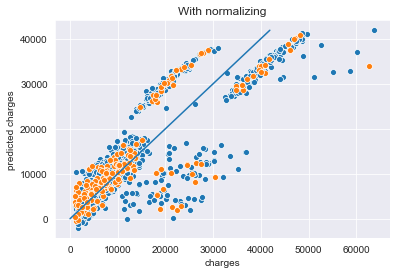

In [19]:
sns.scatterplot(y_train, y_pred_train_norm)
sns.scatterplot(y_test, y_pred_test_norm)
plt.ylabel('predicted charges')
plt.title('With normalizing')
maxim = np.max(np.concatenate([y_pred_train_norm, y_pred_test_norm]))
plt.plot([0,maxim], [0,maxim])

print('RMSE = %f' %mse(y_train, y_pred_train_norm, squared=False))
print('RMSE = %f' %mse(y_test, y_pred_test_norm, squared=False))

I am a bit shocked that these are exactly the same; I need to underdstand why that is.

Clearly these are not great. There appears to be a few groups. Before going on, I just want to upsample the smokers group, simply by duplicating them to see if that helps.

In [20]:
X_train_upsamp = X_train.copy()
y_train_upsamp = y_train.copy()
X_smokers = X_train[X_train['smoker']==1]
y_smokers = y_train[X_train['smoker']==1]
X_smokers.head()
X_train_upsamp = pd.concat([X_train_upsamp, X_smokers, X_smokers, X_smokers, X_smokers])
y_train_upsamp = pd.concat([y_train_upsamp, y_smokers, y_smokers, y_smokers, y_smokers])

print(len(X_train_upsamp[X_train_upsamp['smoker']==1]))
print(len(X_train_upsamp[X_train_upsamp['smoker']==0]))

1160
905


This seemed like the easiest way to do it. They are more similar in size now.

In [21]:
cf_up = LinearRegression()
model_up = cf_up.fit(X_train_upsamp, y_train_upsamp)
y_pred_train_up = model_up.predict(X_train_upsamp)
y_pred_test_up = model_up.predict(X_test)

RMSE = 6725.686984
RMSE = 7365.172496


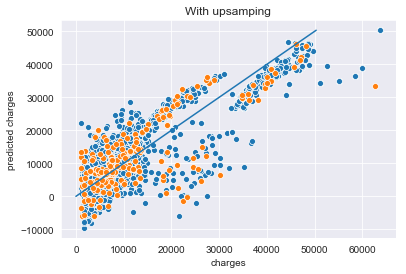

In [22]:
sns.scatterplot(y_train_upsamp, y_pred_train_up)
sns.scatterplot(y_test, y_pred_test_up)
plt.ylabel('predicted charges')
plt.title('With upsamping')
maxim = np.max(np.concatenate([y_pred_train_up, y_pred_test_up]))
plt.plot([0,maxim], [0,maxim])

print('RMSE = %f' %mse(y_train_upsamp, y_pred_train_up, squared=False))
print('RMSE = %f' %mse(y_test, y_pred_test_up, squared=False))

OK, this hasn't helped at all. I will shelve the idea of upsampling.

I have read that when mixing binary and continous features that it's better to scale the continous features by the standard deviation and the binary should be -1 and 1, rather than 0 and 1. Let's try that...

In [23]:
X_train_scale = X_train.copy()
X_test_scale = X_test.copy()

mean_age = X_train['age'].mean()
mean_bmi = X_train['bmi'].mean()
std_age = X_train['age'].std()
std_bmi = X_train['bmi'].std()

X_train_scale['age'] = (X_train['age'] - mean_age) / std_age
X_train_scale['bmi'] = (X_train['bmi'] - mean_bmi) / std_bmi
X_train_scale['smoker'] = X_train['smoker'].replace({0:-1})

# I will do the same for the test data while the means and stds are here.
X_test_scale['age'] = (X_test['age'] - mean_age) / std_age
X_test_scale['bmi'] = (X_test['bmi'] - mean_bmi) / std_bmi
X_test_scale['smoker'] = X_test['smoker'].replace({0:-1})

X_train_scale.head()

age       bmi  smoker
121 -1.487606 -1.135387      -1
304  1.265061  1.175884      -1
660 -0.146563  2.559403      -1
525 -1.487606  0.507643      -1
706  0.841574  1.185616       1

In [24]:
cf_scale = LinearRegression()
model_scale = cf_scale.fit(X_train_scale, y_train)
y_pred_train_scale = model_scale.predict(X_train_scale)
y_pred_test_scale = model_scale.predict(X_test_scale)

RMSE = 5999.092246
RMSE = 6549.121562


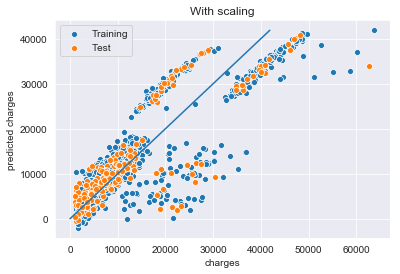

In [25]:
sns.scatterplot(y_train, y_pred_train_scale)
sns.scatterplot(y_test, y_pred_test_scale)
plt.ylabel('predicted charges')
plt.title('With scaling')
plt.legend(('Training', 'Test'))
maxim = np.max(np.concatenate([y_pred_train_scale, y_pred_test_scale]))
plt.plot([0,maxim], [0,maxim])

print('RMSE = %f' %mse(y_train, y_pred_train_scale, squared=False))
print('RMSE = %f' %mse(y_test, y_pred_test_scale, squared=False))

Clearly scaling is having no impact at all!

Let's stick with the original dataset. Let us see if we can separate the groups in the data. I will look at the pairwise plot to see if I can see anything.

<Figure size 720x720 with 0 Axes>

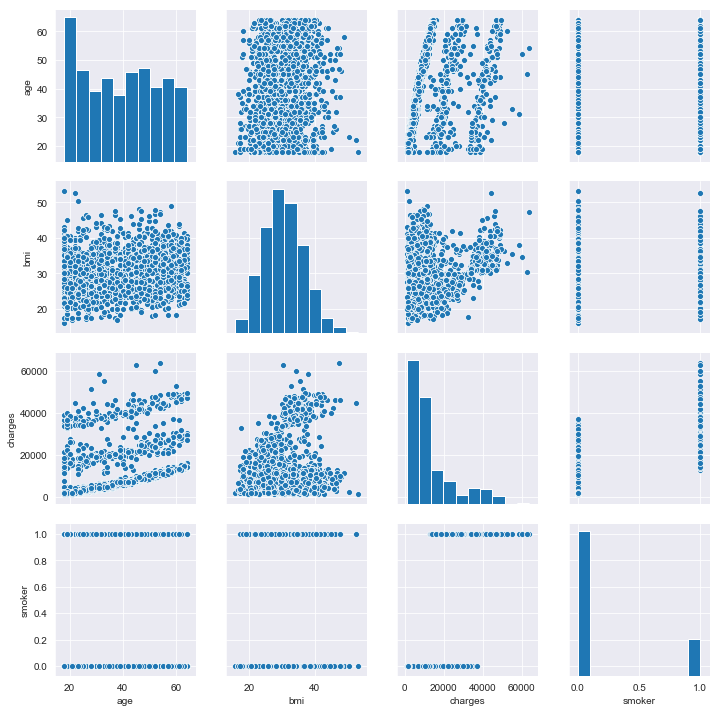

In [26]:
plt.figure(figsize=(10,10))
sns.pairplot(cut_df_onehot)

We can see the upward trend in charges with respect to age and smoking. Lets try splitting the data into smokers and non-smokers. This will cause the fit to smokers to be noisier.

In [27]:
X_train_nonsmoke = X_train[X_train['smoker']==0].drop(columns=['smoker'])
X_test_nonsmoke = X_test[X_test['smoker']==0].drop(columns=['smoker'])

y_train_nonsmoke = y_train[X_train['smoker']==0].drop(columns=['smoker'])
y_test_nonsmoke = y_test[X_test['smoker']==0].drop(columns=['smoker'])

X_train_smoke = X_train[X_train['smoker']==1].drop(columns=['smoker'])
X_test_smoke = X_test[X_test['smoker']==1].drop(columns=['smoker'])

y_train_smoke = y_train[X_train['smoker']==1].drop(columns=['smoker'])
y_test_smoke = y_test[X_test['smoker']==1].drop(columns=['smoker'])


X_train_nonsmoke.head()

age     bmi
121   18  23.750
304   57  38.000
660   37  46.530
525   18  33.880
267   59  32.395

In [28]:
cf_nonsmoke = LinearRegression()
model_nonsmoke = cf_nonsmoke.fit(X_train_nonsmoke, y_train_nonsmoke)
y_pred_train_nonsmoke = model_nonsmoke.predict(X_train_nonsmoke)
y_pred_test_nonsmoke = model_nonsmoke.predict(X_test_nonsmoke)

cf_smoke = LinearRegression()
model_smoke = cf_smoke.fit(X_train_smoke, y_train_smoke)
y_pred_train_smoke = model_smoke.predict(X_train_smoke)
y_pred_test_smoke = model_smoke.predict(X_test_smoke)

RMSE = 4593.079351
RMSE = 5043.245985


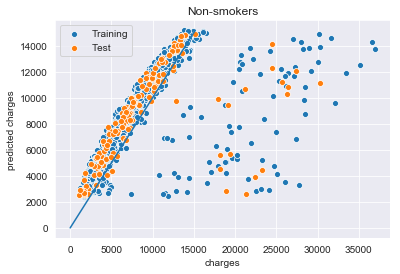

In [29]:
sns.scatterplot(y_train_nonsmoke, y_pred_train_nonsmoke)
sns.scatterplot(y_test_nonsmoke, y_pred_test_nonsmoke)
plt.ylabel('predicted charges')
plt.title('Non-smokers')
plt.legend(('Training', 'Test'))
maxim = np.max(np.concatenate([y_pred_train_nonsmoke, y_pred_test_nonsmoke]))
plt.plot([0,maxim], [0,maxim])

print('RMSE = %f' %mse(y_train_nonsmoke, y_pred_train_nonsmoke, squared=False))
print('RMSE = %f' %mse(y_test_nonsmoke, y_pred_test_nonsmoke, squared=False))

OK, we have done a little better on the non-smoking. Although the main group of this looks a little curved to me. Let's try and fit a polynomial instead.

In [30]:
trans_nonsmoke = PolynomialFeatures(degree=2)

trans_X_train_nonsmoke = trans_nonsmoke.fit_transform(X_train_nonsmoke)
trans_X_test_nonsmoke = trans_nonsmoke.fit_transform(X_test_nonsmoke)

cf_trans_nonsmoke = LinearRegression()
model_trans_nonsmoke = cf_trans_nonsmoke.fit(trans_X_train_nonsmoke, y_train_nonsmoke)
y_pred_trans_train_nonsmoke = model_trans_nonsmoke.predict(trans_X_train_nonsmoke)
y_pred_trans_test_nonsmoke = model_trans_nonsmoke.predict(trans_X_test_nonsmoke)

RMSE = 4560.849642
RMSE = 5016.627320


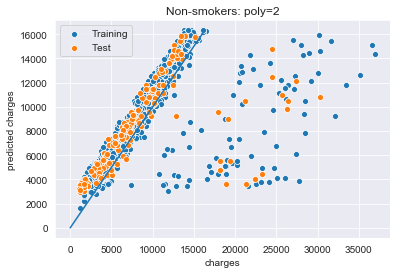

In [31]:
sns.scatterplot(y_train_nonsmoke, y_pred_trans_train_nonsmoke)
sns.scatterplot(y_test_nonsmoke, y_pred_trans_test_nonsmoke)
plt.ylabel('predicted charges')
plt.title('Non-smokers: poly=2')
plt.legend(('Training', 'Test'))
maxim = np.max(np.concatenate([y_pred_trans_train_nonsmoke, y_pred_trans_test_nonsmoke]))
plt.plot([0,maxim], [0,maxim])

print('RMSE = %f' %mse(y_train_nonsmoke, y_pred_trans_train_nonsmoke, squared=False))
print('RMSE = %f' %mse(y_test_nonsmoke, y_pred_trans_test_nonsmoke, squared=False))

Slightly better, but not much. This is obviously dominated by the outliers. This is shifting the main group of the estimates to the left.

We still have to look at the smokers...

RMSE = 5468.098072
RMSE = 6966.603093


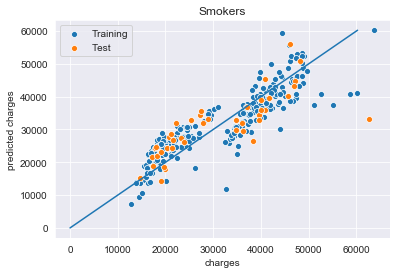

In [32]:
sns.scatterplot(y_train_smoke, y_pred_train_smoke)
sns.scatterplot(y_test_smoke, y_pred_test_smoke)
plt.ylabel('predicted charges')
plt.title('Smokers')
plt.legend(('Training', 'Test'))
maxim = np.max(np.concatenate([y_pred_train_smoke, y_pred_test_smoke]))
plt.plot([0,maxim], [0,maxim])

print('RMSE = %f' %mse(y_train_smoke, y_pred_train_smoke, squared=False))
print('RMSE = %f' %mse(y_test_smoke, y_pred_test_smoke, squared=False))

This seemes fairly evenly scattered about y = x.

Let's go back to the non-smokers. I will cut out the outliers in the training data by cutting on the distance from the line of best fit.

In [33]:
cut_chi2 = 4000

cut_X_train_nonsmoke = X_train_nonsmoke[np.abs(y_train_nonsmoke-y_pred_train_nonsmoke) < cut_chi2]
cut_y_train_nonsmoke = y_train_nonsmoke[np.abs(y_train_nonsmoke-y_pred_train_nonsmoke) < cut_chi2]

In [34]:
cf_cut_nonsmoke = LinearRegression()
model_cut_nonsmoke = cf_cut_nonsmoke.fit(cut_X_train_nonsmoke, cut_y_train_nonsmoke)
y_pred_cut_train_nonsmoke = model_cut_nonsmoke.predict(cut_X_train_nonsmoke)
y_pred_cut_test_nonsmoke = model_cut_nonsmoke.predict(X_test_nonsmoke)

RMSE = 840.088023
RMSE = 5279.383905


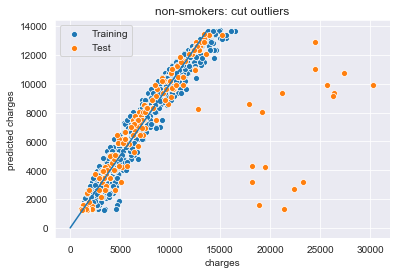

In [35]:
sns.scatterplot(cut_y_train_nonsmoke, y_pred_cut_train_nonsmoke)
sns.scatterplot(y_test_nonsmoke, y_pred_cut_test_nonsmoke)
plt.ylabel('predicted charges')
plt.title('non-smokers: cut outliers')
plt.legend(('Training', 'Test'))
maxim = np.max(np.concatenate([y_pred_cut_train_nonsmoke, y_pred_cut_test_nonsmoke]))
plt.plot([0,maxim], [0,maxim])

print('RMSE = %f' %mse(cut_y_train_nonsmoke, y_pred_cut_train_nonsmoke, squared=False))
print('RMSE = %f' %mse(y_test_nonsmoke, y_pred_cut_test_nonsmoke, squared=False))

Again the curve is curved, so we can fit a polynomial.

In [36]:
trans_cut_nonsmoke = PolynomialFeatures(degree=2)

trans_cut_X_train_nonsmoke = trans_cut_nonsmoke.fit_transform(cut_X_train_nonsmoke)
trans_cut_X_test_nonsmoke = trans_cut_nonsmoke.fit_transform(X_test_nonsmoke)

cf_trans_cut_nonsmoke = LinearRegression()
model_trans_nonsmoke = cf_trans_cut_nonsmoke.fit(trans_cut_X_train_nonsmoke, cut_y_train_nonsmoke)
y_pred_trans_cut_train_nonsmoke = model_trans_nonsmoke.predict(trans_cut_X_train_nonsmoke)
y_pred_trans_cut_test_nonsmoke = model_trans_nonsmoke.predict(trans_cut_X_test_nonsmoke)

RMSE = 760.810226
RMSE = 5279.822859


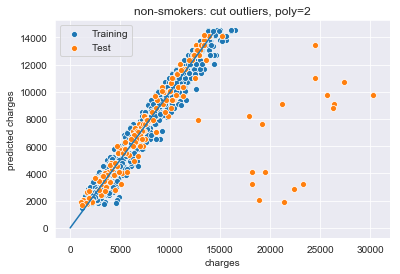

In [37]:
sns.scatterplot(cut_y_train_nonsmoke, y_pred_trans_cut_train_nonsmoke)
sns.scatterplot(y_test_nonsmoke, y_pred_trans_cut_test_nonsmoke)
plt.ylabel('predicted charges')
plt.title('non-smokers: cut outliers, poly=2')
plt.legend(('Training', 'Test'))
maxim = np.max(np.concatenate([y_pred_trans_cut_train_nonsmoke, y_pred_trans_cut_test_nonsmoke]))
plt.plot([0,maxim], [0,maxim])

print('RMSE = %f' %mse(cut_y_train_nonsmoke, y_pred_trans_cut_train_nonsmoke, squared=False))
print('RMSE = %f' %mse(y_test_nonsmoke, y_pred_trans_cut_test_nonsmoke, squared=False))

This is now fitting well to the main group of data and is not attempting to model for the outliers. This seems like it may be more useful in some cases than the model above where we are shifted by the outliers and cannot model the main group well.

### Conclusion

We have seen that we can model fairly accurately for the medical costs if we split the data into smokers and non-smokers.

There are, however, outliers in the non-smokere data with large charges that are not easily modelled using a linear regression model. It may be more beneficial to model for the bulk of the main group of medical costs by cutting out outliers. In this case, we have shown that we can accuarely model for the main group using a polynomial model with degree 2.